<a href="https://colab.research.google.com/github/seonae0223/machine_learning/blob/main/04_01_Text_Mining_Korean_Review_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import urllib.request

import matplotlib.pyplot as plt

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 17.0 MB/s eta 0:00:00


In [ ]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7cf632499cf0>)

# 데이터 준비

In [ ]:
df_train = pd.read_table("ratings_train.txt")
df_test  = pd.read_table("ratings_test.txt")

In [ ]:
df_train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


* `id` : 리뷰 id(index)
* `document` : 리뷰 텍스트
* `label` : `0`->부정리뷰, `1`->긍정 리뷰

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
# 1. 중복 데이터 제거
print(df_train['document'].nunique())
df_train = df_train.drop_duplicates(subset=['document'])
df_train.nunique()

146182


,0
id,146183
document,146182
label,2


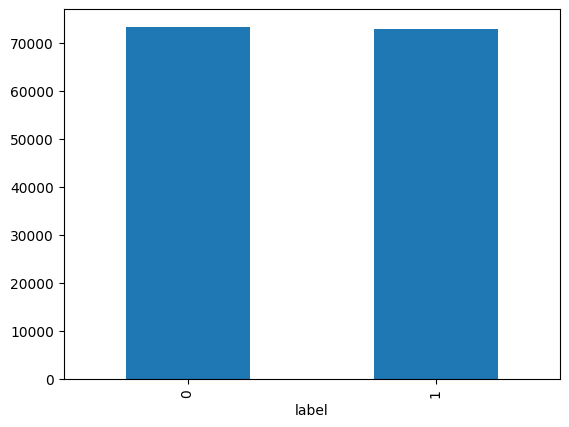

In [ ]:
# 레이블 비율 확인
#  - 한쪽으로 치우쳐지지 않게 훈련하기 위해서는 2개의 레이블의 비율이 비슷해야 한다.
#  - Imbalanced 하다면 SMOTE 같은 샘플링 기법이나, 많은 쪽을 탈락 시키는 기법을 고려

df_train['label'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
df_train = df_train.dropna(how='any') # NaN값 제거
df_train.isnull().values.sum() # NaN 값의 개수를 세었을 때 0이면 NaN값이 하나도 없는 것

0

In [ ]:
# 정규식을 통한 텍스트 정제
import re

# df_train['document'] = df_train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
df_train['document'] = df_train['document'].apply(lambda x : re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x))
df_train.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
# 정규식 정제에 의해 내용이 아무것도 없는 리뷰가 몇 개인지 확인
#  - 한글, 공백 한칸 빼고 다 지웠기 때문에, 영어 또는 특수기호로만
#    이루어진 리뷰는 아무 내용도 없음..
df_train.loc[df_train['document'] =='', 'document'].value_counts()

,count
document,
,391


In [ ]:
# 아무 문자열도 들어있지 않은 내용을 강제로 nan값으로 치환
df_train['document'].replace("", np.nan, inplace=True)
df_train = df_train.dropna(how='any')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145791 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        145791 non-null  int64 
 1   document  145791 non-null  object
 2   label     145791 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB


In [ ]:
# 테스트 데이터도 훈련 데이터와 동일하게 처리
df_test.drop_duplicates(subset=['document'], inplace=True)
df_test['document'] = df_test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "").str.strip()
df_test['document'].replace('', np.nan, inplace=True)
df_test = df_test.dropna(how='any')

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49157 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49157 non-null  int64 
 1   document  49157 non-null  object
 2   label     49157 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [ ]:
# 훈련 데이터 형태소 분리
from tqdm import tqdm_notebook
from konlpy.tag import Okt

okt = Okt()
X_train = []

for sentence in tqdm_notebook(df_train['document']):
  # 형태소 분리 및 정규화, 어간추출
  temp_X = okt.morphs(sentence, stem=True, norm=True)
  X_train.append(temp_X)

<ipython-input-20-97257c52bad6>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm_notebook(df_train['document']):


  0%|          | 0/145791 [00:00<?, ?it/s]

In [ ]:
import pickle

with open("X_train.pkl", "wb") as f:
  pickle.dump(X_train, f)

In [ ]:
with open("X_train.pkl","rb") as fr:
  X_train = pickle.load(fr)

X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '한', '다']]

In [ ]:
y_train = df_train['label'].values
y_train[:3]

array([0, 1, 0])

# 텍스트 벡터화
- BOW 생성

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    # ngram_range=(1, 2), # bigram 까지 생성
    # min_df=0.05, # 하위 빈도 5퍼센트 미만은 사용하지 않겠다.
    # max_df=0.95  # 상위 빈도 95퍼센트 이상은 사용하지 않음.
)

X_train = [ ' '.join(words) for words in X_train ]
X = tfidf_vectorizer.fit_transform(X_train)
X

<145791x41347 sparse matrix of type '<class 'numpy.float64'>'
	with 1214167 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_vectorizer.vocabulary_

{'더빙': 8151,
 '진짜': 33005,
 '짜증나다': 33207,
 '목소리': 12708,
 '포스터': 37920,
 '보고': 15612,
 '초딩': 34307,
 '영화': 25084,
 '오버': 25384,
 '연기': 24758,
 '조차': 31701,
 '가볍다': 670,
 '않다': 22780,
 '무재': 13138,
 '밓었': 13930,
 '다그': 7241,
 '래서': 10185,
 '보다': 15643,
 '추천': 34692,
 '교도소': 3247,
 '이야기': 28383,
 '구먼': 3373,
 '솔직하다': 19704,
 '재미': 30175,
 '없다': 24104,
 '평점': 37816,
 '조정': 31676,
 '사이': 17783,
 '몬페': 12761,
 '익살스럽다': 28769,
 '돋보이다': 8723,
 '스파이더맨': 20692,
 '에서': 24269,
 '늙다': 7107,
 '보이다': 15756,
 '하다': 38685,
 '커스틴': 35377,
 '던스트': 8219,
 '너무나도': 6365,
 '이쁘다': 28233,
 '걸음': 1897,
 '떼다': 9738,
 '부터': 16347,
 '초등학교': 34304,
 '학년': 38889,
 '생인': 18460,
 '살다': 17995,
 'ㅋㅋㅋ': 279,
 '반개': 14335,
 '아깝다': 22056,
 '원작': 26775,
 '긴장감': 4535,
 '제대로': 31313,
 '살리다': 18008,
 '나오다': 5687,
 '이응경': 28488,
 '길용우': 4559,
 '생활': 18482,
 '인지': 28941,
 '정말': 31022,
 '해도': 39315,
 '그것': 3864,
 '보단': 15648,
 '낫다': 6167,
 '납치': 6165,
 '감금': 1019,
 '반복': 14379,
 '드라마': 9165,
 '가족': 799,
 '사람': 17632,
 '액션': 231

# 로지스틱 회귀

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=100000).fit(X, y_train)
log_reg

LogisticRegression(max_iter=100000)

In [ ]:
# 성능 평가
df_test.drop_duplicates(subset=['document'], inplace=True)
df_test['document'] = df_test['document'].apply(lambda x : re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x))
df_test['document'].replace('', np.nan, inplace=True)
df_test = df_test.dropna(how='any')

df_test

,id,document,label
0,6270596,굳 ㅋ,1
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
5,7898805,음악이 주가 된 최고의 음악영화,1
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49997,9072549,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0


In [ ]:
# 형태소 분리
X_test = []

for test_sentence in tqdm_notebook(df_test['document']):
  temp_X = okt.morphs(test_sentence, norm=True, stem=True)
  X_test.append(' '.join(temp_X))

X_test

<ipython-input-45-e1b2d8592061>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_sentence in tqdm_notebook(df_test['document']):


  0%|          | 0/48995 [00:00<?, ?it/s]

['굳다 ㅋ',
 '뭐 야 이 평점 들 은 나쁘다 않다 점 짜다 리 는 더 더욱 아니다',
 '지루하다 않다 완전 막장 임 돈 주다 보기 에는',
 '만 아니다 별 다섯 개 주다 왜 로 나오다 제 심기 를 불편하다 하다',
 '음악 이 주가 되다 최고 의 음악 영화',
 '진정하다 쓰레기',
 '마치 미국 애니 에서 튀어나오다 한 창의력 없다 로봇 디자인 부터가 고개 를 젖다 하다',
 '갈수록 개판 되다 중국영화 유치하다 내용 없다 폼 잡다 끝나다 말 도 안되다 무기 에 유치하다 남무 아 그리다 동사서독 같다 영화 가 이 것 은 류 아 류작 이다',
 '이별 의 아픔 뒤 에 찾아오다 새롭다 인연 의 기쁨 모든 사람 이 그렇다 않다',
 '괜찮다 오랜 만 포켓몬스터 잼밌 어 요',
 '한국 독립영화 의 한계 그렇게 아버지 가 되다 비교 되다',
 '청춘 은 아름답다 그 아름답다 움 은 이성 을 흔들다 놓다 찰나 의 아름답다 움 을 자다 포착 한 섬세하다 아름답다 수채화 같다 퀴어 영화 이다',
 '눈 에 보이다 반전 이다 영화 의 흡인 력 은 사라지다 않다',
 '스토리 연출 연기 비주 얼 등 영화 의 기본 조차 안되다 영화 에 무슨 평 을 해 이렇다 영화 찍다 김문옥 감독 은 내 가 영화 경력 이 몇 인데 조무래기 들 이 내 영화 를 평론 하다 같다 마인드 에 빠지다',
 '소위 ㅈ 문 가라 는 평점 은 뭐 냐',
 '최고',
 '발연기 도저히 못 보다 진짜 이렇게 연기 를 못 하다 상상 도 못 하다',
 '나이스',
 '별 재미 도 없다 우려 먹다 챔프 에서 방송 몇번 하다 ㅋㅋㅋ',
 '일 의 금요일 나이트메어 시리즈 와 함께 가장 많다 시리즈 를 양산 해내다 헬레 이 저 시리즈 의 첫 편 작가 의 상상력 이 돋보이다 작품 이며 갈고리 로 사지 찢다 고어씬 은 지금 보더 라도 상당하다 잔인하다 충격 적 이다',
 '나름 교훈 돋다 하지만 어쩔 수없이 저 평점 받다 없다 저 질 섹스 코미디',
 '꽤 재밌다 보다 영화 이다',
 '민주화 시대 의 억눌리다 

In [ ]:
X_test_vector = tfidf_vectorizer.transform(X_test)

In [ ]:
y_test = df_test['label']

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(log_reg.predict(X_test_vector), y_test)

0.8310439840800081

In [ ]:
def sentiment_predict(sentence):
  sentence_norm_stem = okt.morphs(sentence, stem=True, norm=True)
  sentence_test = ' '.join(sentence_norm_stem)

  text_vector = tfidf_vectorizer.transform([sentence_test])

  pred = log_reg.predict(text_vector)
  print(sentence, "====>", pred)

In [ ]:
sentiment_predict("영화가 너무 재미 있어요")

영화가 너무 재미 있어요 ====> [1]


In [ ]:
sentiment_predict("아 진짜 영화 너무 지루하다")

아 진짜 영화 너무 지루하다 ====> [0]


In [ ]:
sentiment_predict("영화를 보다가 너무 졸려서 뒷 사람이 차는 것도 몰랐네요")

영화를 보다가 너무 졸려서 뒷 사람이 차는 것도 몰랐네요 ====> [0]


In [ ]:
sentiment_predict("아 오늘 수업 진짜 개꿀잼")

아 오늘 수업 진짜 개꿀잼 ====> [1]


In [ ]:
sentiment_predict("아 오늘 수업 진짜 개꿀잼")